<a href="https://colab.research.google.com/github/constantinpape/dl-teaching-resources/blob/main/exercises/classification/1_data_preperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation for a classification model

In our first exercise, we will download the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,0000 small images (32 x 32 pixel) which fall into 10 different classes (automobile, airplane, ...).

Here, we will learn how to visualize the data and prepare it for training a classifier model.

## Import python libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from tqdm import tqdm

## Download and read the data

We download and load the images and corresponding labels to inspect them (and later use it to train a classifier).

The data is organised in a folder structure as follows:

```
train/
  airplane/
    001.png
    002.png
    ...
  automobile/
    001.png
    002.png
    ...
```

and similarly for the test data.

In [2]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

cifar-10-python.tar.gz does not exists.
167kKB [00:08, 19.8kKB/s]                                                       
Saving test images: 100%|████████████████| 10000/10000 [00:32<00:00, 310.62it/s]


In [3]:
# first, list the categories available in the data
data_dir = os.path.join(cifar_dir, "train")
categories = os.listdir(data_dir)
categories.sort()
print(categories)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# next load the images and labels
images = []
labels = []
for label_id, category in tqdm(enumerate(categories), total=len(categories)):
    category_dir = os.path.join(data_dir, category)
    image_names = os.listdir(category_dir)
    for im_name in image_names:
        im_file = os.path.join(category_dir, im_name)
        images.append(imread(im_file))
        labels.append(label_id)
        
# make numpy arrays out of the lists
# for th images, we stack along a new first axis
images = np.concatenate([im[None] for im in images], axis=0)
labels = np.array(labels)

print("Number of images:", len(images))
print("Number of labels:", len(labels))

100%|██████████| 10/10 [02:31<00:00, 15.15s/it]


Number of images: 50000
Number of labels: 50000


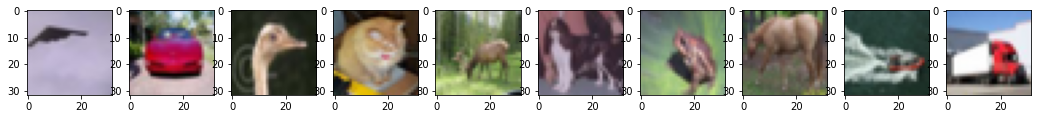

In [5]:
# plot one image for each category
fig, ax = plt.subplots(1, 10, figsize=(18, 6))
label_list = labels.tolist()
for label_id, category in enumerate(categories):
    ax[label_id].imshow(images[label_list.index(label_id)])
    # ax[label_id].set_title(category)
plt.show()

## Convolutional Filters

As a first step we apply some simple filters on the images.
In particular, we use convolutional filters that can be expressed as convolution of a kernel with the image, which will be important for the concept of Convolutional Neural Networks that we will introduce later.

For now, we will use some filter available in [skimage.filters](https://scikit-image.org/docs/dev/api/skimage.filters.html).

In [6]:
import skimage.filters as filters
image = images[0]
filtered_gaussian = filters.gaussian(image, sigma=1., multichannel=True)
filtered_laplacian = filters.laplace(image)

/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_17217/4223603429.py:3: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  filtered_gaussian = filters.gaussian(image, sigma=1., multichannel=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


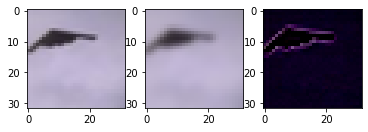

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image)
ax[1].imshow(filtered_gaussian)
ax[2].imshow(filtered_laplacian)

## Preparation for pytorch

In order to use the CIFAR data to with pytorch, we need to transform the data into the compatible data structures. In particular, pytorch expects all numerical data as [torch.tensor](https://pytorch.org/docs/stable/tensors.html).
To provide the data as tensors, we will wrap them in a [torch.dataset](https://pytorch.org/docs/stable/data.html) and implement a mechanism to apply transformations to the data on the fly. We will use these transformations to bring the data into a format that pytorch can ingest and later also use them for other purposes such as data augmentation.

In [8]:
import torch
# datasets have to be sub-classes from torch.util.data.Dataset
from torch.utils.data import Dataset

class DatasetWithTransform(Dataset):
    """ Our minimal dataset class. It holds data and target
    as well as optional transforms that are applied to the data and target
    on the fly when a batch is requested via the [] operator.
    """
    def __init__(self, data, target, transform=None):
        assert isinstance(data, np.ndarray)
        assert isinstance(target, np.ndarray)
        self.data = data
        self.target = target
        if transform is not None:
            assert callable(transform)
        self.transform = transform

    # exposes the [] operator of our class
    def __getitem__(self, index):
        data, target = self.data[index], self.target[index]

        # if we have transformations, apply them to the data and target
        if self.transform is not None:
            data, target = self.transform(data, target)
        return data, target

    def __len__(self):
        return self.data.shape[0]

In [9]:
# what transofrmations do we need to feed this data to pytorch?

# first, let's check the shape of our images:
print(image.shape)

(32, 32, 3)


In [10]:
# as we see, the images are stored in the order width, height, channel (WHC), 
# i.e. the first two axes are the image axes and the last axis
# corresponds to the color channel.
# pytorch however expects the color channel as first axis, i.e. CWH.
# so our first transform switches the chanels

# note that we have implemented the dataset in such a way, that the transforms
# are functions that take bot the data (or image) and target as parameters.
# thus we here accept the target (which is just the class label for the image) 
# as second parameter and return it without changing it
def to_channel_first(image, target):
    """ Transform images with color channel last (WHC) to channel first (CWH)
    """
    # put channel first
    image = image.transpose((2, 0, 1))
    return image, target

In [11]:
# next, let's see what datatype and value range our images have
print(image.dtype)
print(image.min(), image.max())

uint8
34 218


In [12]:
# as we can see, the images are stored as 8 bit integers with a value range [0, 255]
# instead, torch expects images as 32 bit floats that should also be normalized to a 'reasonable' data range.
# here, we normalize the image such that all channels are in range 0 to 1
def normalize(image, target, channel_wise=True):
    eps = 1.e-6
    image = image.astype('float32')
    chan_min = image.min(axis=(1, 2), keepdims=True)
    image -= chan_min
    chan_max = image.max(axis=(1, 2), keepdims=True)
    image /= (chan_max + eps)
    return image, target


# finally, we need to transform the input from a numpy array to a torch tensor
# and also return the target (which in our case is a scalar) as a tensor
def to_tensor(image, target):
    return torch.from_numpy(image), torch.tensor([target], dtype=torch.int64)
    

# we also need a way to apply multiple transforms
# (note that alternatively we could also have accepted a list of transforms
# in DatasetWithTransform)
def compose(image, target, transforms):
    for trafo in transforms:
        image, target = trafo(image, target)
    return image, target

In [13]:
# create the dataset with the transformations
from functools import partial  # to bind function arguments

trafos = [to_channel_first, normalize, to_tensor]
trafo = partial(compose, transforms=trafos)

dataset = DatasetWithTransform(images, labels, transform=trafo)

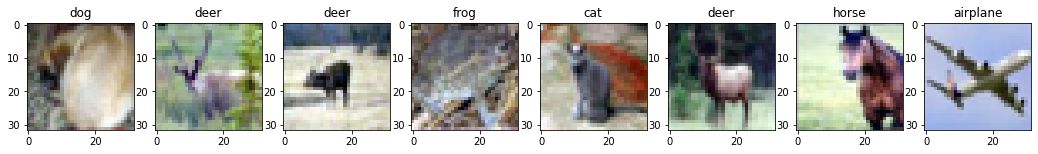

In [14]:
# function to show an image target pair returned from the dataset
def show_image(ax, image, target):
    # need to go back to numpy array and WHC axis order
    image = image.numpy().transpose((1, 2, 0))
    # find the label name
    label = categories[target.item()]
    ax.imshow(image)
    ax.set_title(label)

    
# sample a few images from the dataset and check their label
n_images = len(dataset)
n_samples = 8

fig, ax = plt.subplots(1, n_samples, figsize=(18, 4))
for sample in range(n_samples):
    # datasets are random access, so we can request
    # an image / target at an arbitrary index
    sample_id = np.random.randint(0, n_images)
    image, target = dataset[sample_id]
    
    # make sure that the image is in range 0, 1
    assert np.isclose(image.min(), 0.)
    assert np.isclose(image.max(), 1.)
    
    # add the image to our plots
    show_image(ax[sample], image, target)

## Torchvision

Note: there is a torch library for computer vision: [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). It has many datasets, transformations etc. already. For example it also has a [prefab cifar dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar).

We do not use torchvision here for two reasons:
- to show how to implement a torch.dataset yourself, so that you can implement it for new data you are working with
- torchvision uses [PIL](https://pillow.readthedocs.io/en/stable/) to represent images, which is rather outdated

Still, torchvision contains helpful functionality and many datasets, so it's a very useful library.

## Tasks

- Apply more advanced transforms in the dataset: for example you could blur the images or rotate them on the fly.

In [24]:
from skimage.filters import gaussian

def blur(image, target):
    """Apply a gaussian blur to images."""
    # images have very few pixels, so we will keep the sigma value equal to 1
    image = gaussian(image, sigma=1)
    return image, target

In [38]:
from skimage.transform import rotate

def rotate_random(image, target):
    """Rotate:image by a random number of degrees."""
    angle = np.random.randint(0, 360)  # degree of rotation
    image = rotate(image, angle)
    return image, target

In [28]:
from skimage.filters import sobel

def sobel_edges(image, target):
    """Apply sobel edge filter to image."""
    image = sobel(image)
    return image, target

### Looking at the output of our new filters / data augmentations

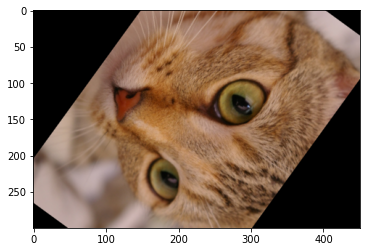

In [39]:
result_img, result_target = rotate_random(cat(), 'target')
plt.imshow(result_img)

(300, 451, 3)


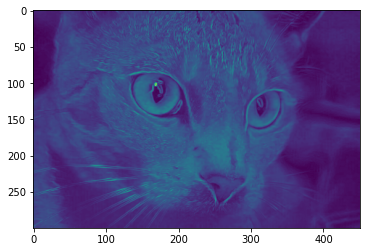

In [23]:
from skimage.data import camera, cat
from skimage.filters import sobel

result = sobel(cat())
print(result.shape)
plt.imshow(result[...,2])

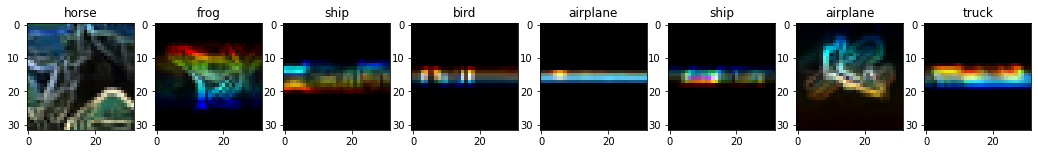

In [42]:

trafos = [to_channel_first, sobel_edges, rotate_random, normalize, to_tensor]
trafo = partial(compose, transforms=trafos)

dataset = DatasetWithTransform(images, labels, transform=trafo)
# sample a few images from the dataset and check their label
n_images = len(dataset)
n_samples = 8

fig, ax = plt.subplots(1, n_samples, figsize=(18, 4))
for sample in range(n_samples):
    # datasets are random access, so we can request
    # an image / target at an arbitrary index
    sample_id = np.random.randint(0, n_images)
    image, target = dataset[sample_id]
    
    # make sure that the image is in range 0, 1
    assert np.isclose(image.min(), 0.)
    assert np.isclose(image.max(), 1.)
    
    # add the image to our plots
    show_image(ax[sample], image, target)

/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


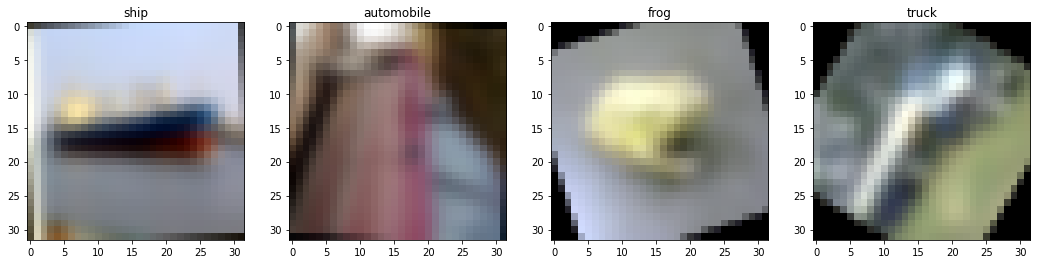

In [52]:

trafos = [blur, rotate_random, to_channel_first, normalize, to_tensor]
trafo = partial(compose, transforms=trafos)

dataset = DatasetWithTransform(images, labels, transform=trafo)
# sample a few images from the dataset and check their label
n_images = len(dataset)
n_samples = 4

fig, ax = plt.subplots(1, n_samples, figsize=(18, 4))
for sample in range(n_samples):
    # datasets are random access, so we can request
    # an image / target at an arbitrary index
    sample_id = np.random.randint(0, n_images)
    image, target = dataset[sample_id]
    
    # make sure that the image is in range 0, 1
    assert np.isclose(image.min(), 0.)
    assert np.isclose(image.max(), 1.)
    
    # add the image to our plots
    show_image(ax[sample], image, target)

In [53]:
# It's important to put the to_channel_first, normalize, and to_tensor operations at the END of your transform sequence (or re-write the transforms to expect the channel axis at the back - but that doesn't make as much sense since skimage prefers the other way around)